# Imports

In [ ]:
from pathlib import Path
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import scipy as sci

In [ ]:
# config
TRANSECT_NAME = 'TKA'

# Load metadata

In [ ]:
# load metadata

p = Path("data/ibutton/metadata/deployment_log.xlsx")
deployments = pd.read_excel(p, comment="#")
deployments

NameError: name 'Path' is not defined

# Load data

In [ ]:
# make list of files

dirname = Path("/Users/drotto/src/jirp/data/ibutton")
fnames = list(dirname.iterdir())
fnames = [f for f in fnames if f.suffix == '.csv']  # this is where more filter conditions should go
ids = [f.stem.split('-')[2] for f in fnames]
transects = [f.stem.split('-')[1] for f in fnames]
years = [f.stem.split('-')[0] for f in fnames]
fname_metadata = pd.DataFrame(dict(id=ids, year=years, transect_name=transects, fname=fnames))
print(fname_metadata)

    id year transect_name                                              fname
0    E   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-E.csv
1    R   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-R.csv
2    S   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-S.csv
3    Q   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-Q.csv
4    G   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-G.csv
5    T   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-T.csv
6    A   23           TKB   /Users/drotto/src/jirp/data/ibutton/23-TKB-A.csv
7   II   23           TKA  /Users/drotto/src/jirp/data/ibutton/23-TKA-II.csv
8   FF   23           TKA  /Users/drotto/src/jirp/data/ibutton/23-TKA-FF.csv
9   RR   23           TKA  /Users/drotto/src/jirp/data/ibutton/23-TKA-RR.csv
10  DD   23           TKA  /Users/drotto/src/jirp/data/ibutton/23-TKA-DD.csv
11  JJ   23           TKA  /Users/drotto/src/jirp/data/ibutton/23-TKA-JJ.csv

In [ ]:
# load the data from the fname dataframe

files = []
for _, row in fname_metadata.iterrows():
    d = pd.read_csv(row.fname, skiprows=15)
    d.columns = ['datetime', 'unit', 'T']
    d['datetime'] = pd.to_datetime(d['datetime'])
    d['sensor_id'] = row.id
    d['year'] = row.year
    d['transect_name'] = row.transect_name
    d = d.drop(columns=['unit'])
    files.append(d)
df = pd.concat(files, ignore_index=True)
df

,datetime,T,sensor_id,year,transect_name
0,2023-07-08 12:46:00,21.5,E,23,TKB
1,2023-07-08 12:56:00,21.0,E,23,TKB
2,2023-07-08 13:06:00,20.5,E,23,TKB
3,2023-07-08 13:16:00,20.5,E,23,TKB
4,2023-07-08 13:26:00,20.0,E,23,TKB
...,...,...,...,...,...
11599,2023-07-13 15:10:00,25.5,I,23,TKB
11600,2023-07-13 15:20:00,25.5,I,23,TKB
11601,2023-07-13 15:30:00,25.5,I,23,TKB
11602,2023-07-13 15:40:00,24.5,I,23,TKB


In [ ]:
# filter deployments
#deployments = deployments[deployments.datetime_out.dt.date == pd.to_datetime(DEPLOY_DATE, format='%y%m%d')]
deployments = deployments.loc[deployments.transect_name == TRANSECT_NAME]
deployments['housing'] = deployments['housing'].fillna('PVC')
deployments

/var/folders/bb/wssqxcxj4tgg0s9fdw74731m0000gn/T/ipykernel_30669/2229967772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deployments['housing'] = deployments['housing'].fillna('PVC')


,sensor_id,transect_name,point_id,elevation,datetime_out,datetime_in,initial_height,final_height,surface,housing,stake,aspect,notes
19,EE,TKA,TKA-001,1098,2023-07-10 11:40:00,2023-07-12 11:37:00,55,42.0,snow,PVC,bamboo,NW,NW aspect
20,DD,TKA,TKA-002,1107,2023-07-10 11:55:00,2023-07-12 11:43:00,50,40.0,snow,PVC,bamboo,SW,SW aspect
21,II,TKA,TKA-003,1164,2023-07-10 12:10:00,2023-07-12 11:52:00,50,55.0,snow,PVC,bamboo,NW,NW aspect
22,FF,TKA,TKA-004,1169,2023-07-10 12:20:00,2023-07-12 11:57:00,50,45.0,snow,PVC,bamboo,SW,SW aspect
23,JJ,TKA,TKA-005,1412,2023-07-10 13:37:00,2023-07-12 12:57:00,57,50.0,snow,PVC,bamboo,None,saddle between false summit and summit
24,RR,TKA,TKA-006,1514,2023-07-10 14:45:00,2023-07-12 13:19:00,50,46.0,snow,PVC,bamboo,None,summit


In [ ]:
# filter data with deployments and add metadata
print(f"Initial nobs = {len(df)}")
groups = []
for tup, group in df.groupby(['sensor_id', 'transect_name']):
    id, transect_name = tup
    deployment = deployments.loc[(deployments.sensor_id == id) & (deployments.transect_name == group['transect_name'].iloc[0])].squeeze()

    if len(deployment) == 0:
        continue
    group = group.loc[(group['datetime'] > deployment['datetime_out']) & (group["datetime"] < deployment["datetime_in"])]
    # add metadata
    group['elevation'] = deployment['elevation']
    group['surface'] = deployment['surface']
    group['housing'] = deployment['housing']
    group['initial_height'] = deployment['initial_height']
    group['final_height'] = deployment['final_height']
    group['aspect'] = deployment['aspect']

    groups.append(group)
df = pd.concat(groups, ignore_index=True)
print(f"Filtered nobs = {len(df)}")
df

Initial nobs = 1710
Filtered nobs = 1710


,datetime,T,sensor_id,year,transect_name,elevation,surface,housing,initial_height,final_height,aspect
0,2023-07-10 11:56:00,21.5,DD,23,TKA,1107,snow,PVC,50,40.0,SW
1,2023-07-10 12:06:00,14.0,DD,23,TKA,1107,snow,PVC,50,40.0,SW
2,2023-07-10 12:16:00,11.0,DD,23,TKA,1107,snow,PVC,50,40.0,SW
3,2023-07-10 12:26:00,11.0,DD,23,TKA,1107,snow,PVC,50,40.0,SW
4,2023-07-10 12:36:00,11.5,DD,23,TKA,1107,snow,PVC,50,40.0,SW
...,...,...,...,...,...,...,...,...,...,...,...
1705,2023-07-12 12:35:00,7.5,RR,23,TKA,1514,snow,PVC,50,46.0,None
1706,2023-07-12 12:45:00,7.0,RR,23,TKA,1514,snow,PVC,50,46.0,None
1707,2023-07-12 12:55:00,8.0,RR,23,TKA,1514,snow,PVC,50,46.0,None
1708,2023-07-12 13:05:00,8.0,RR,23,TKA,1514,snow,PVC,50,46.0,None


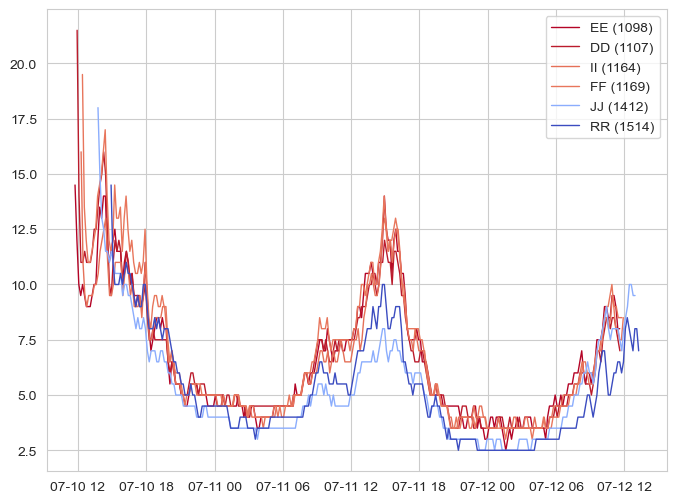

In [ ]:
# quick look at data
fig, ax = plt.subplots(1,1, dpi=100, figsize=(8, 6))
norm = mpl.colors.Normalize(vmin=df['elevation'].min(), vmax=df['elevation'].max())
cmap = plt.cm.coolwarm_r
for tup, group in df.groupby(['elevation', 'sensor_id']):
    elevation, id = tup
    ax.plot(group['datetime'], group['T'], c=cmap(norm(elevation)), label=f"{id} ({elevation})", lw=1)
    ax.legend()

<AxesSubplot:xlabel='elevation', ylabel='T'>

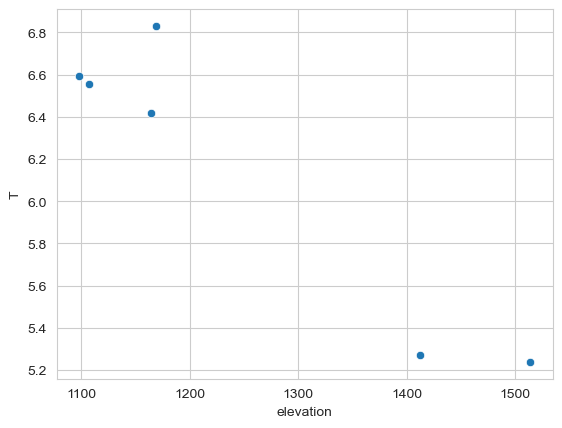

In [ ]:
# first look at the lapse rate
# going to assume linear lapse rate
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=df.groupby('elevation').mean(numeric_only=True).reset_index(), x='elevation', y='T')


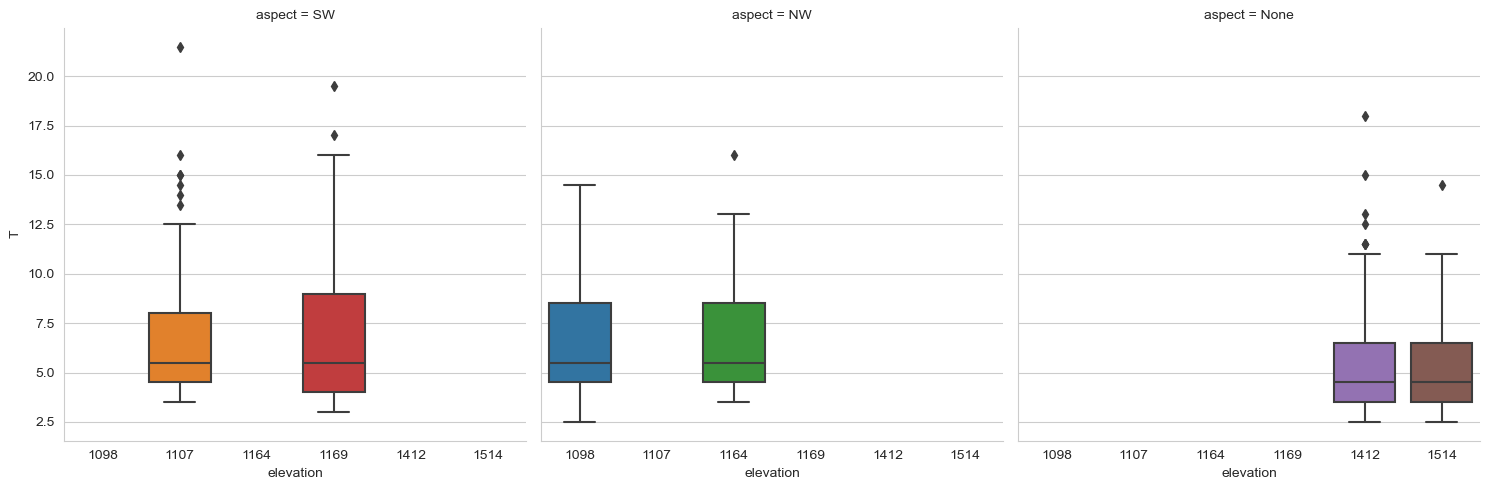

In [ ]:
sns.catplot(df, x='elevation', y='T', col='aspect', kind='box')


# Calculate lapse rate

In [ ]:
date_mask = (df.datetime >= deployments.datetime_out.max() + pd.Timedelta('1H')) & (df.datetime <= deployments.datetime_in.min())  # mask to times when the sensors overlap
nw_aspect = df.loc[df.sensor_id.isin(['EE', 'II', 'JJ', 'RR']) & date_mask] # sensors on NW aspect + summit
sw_aspect = df.loc[df.sensor_id.isin(['DD', 'FF', 'JJ', 'RR']) & date_mask] # sensors on SW aspect + summit


In [ ]:
# whole-period lapse rate
nw = sci.stats.linregress(nw_aspect['elevation']/1000, nw_aspect['T'])
print("NW lapse:", nw)

sw = sci.stats.linregress(sw_aspect['elevation']/1000, sw_aspect['T'])
print("SW lapse:", sw)

NW lapse: LinregressResult(slope=-3.2546950062510636, intercept=9.75164245341066, rvalue=-0.24607200294676362, pvalue=4.980446697338969e-16, stderr=0.3948792312587974, intercept_stderr=0.5166146292118832)
SW lapse: LinregressResult(slope=-3.3305220690290565, intercept=9.881522115371412, rvalue=-0.24176188289512987, pvalue=1.6969620991414638e-15, stderr=0.4119383921382017, intercept_stderr=0.5402241851361024)


## Comparison by aspect

Text(0.5, 1.0, 'Aspect comparison')

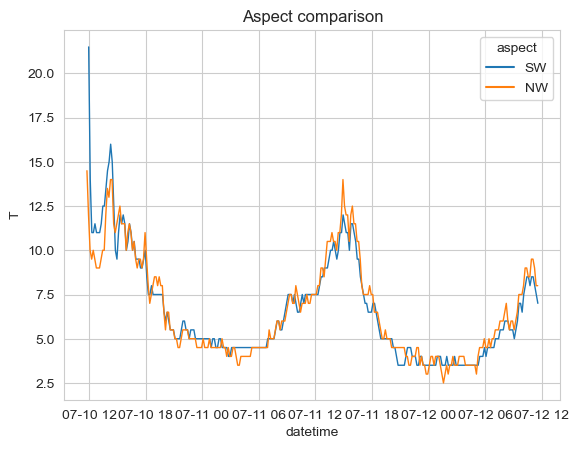

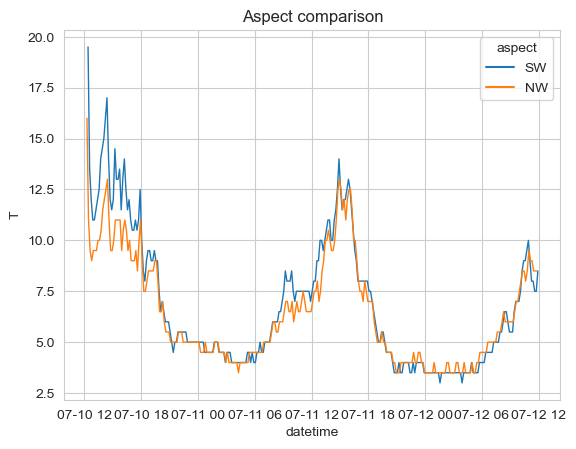

In [ ]:
g = df.loc[df.sensor_id.isin(['EE', 'DD'])]
fig, ax = plt.subplots(1,1)
sns.lineplot(g, x='datetime', y='T', hue='aspect', ax=ax, lw=1)
ax.set_title(f"Aspect comparison")

g = df.loc[df.sensor_id.isin(['II', 'FF'])]
fig, ax = plt.subplots(1,1)
sns.lineplot(g, x='datetime', y='T', hue='aspect', ax=ax, lw=1)
ax.set_title(f"Aspect comparison")

              datetime         nw         sw
0  2023-07-10 15:00:00  -1.090524  -2.563216
1  2023-07-10 16:00:00  -1.036671  -3.525161
2  2023-07-10 17:00:00  -1.598585  -3.082806
3  2023-07-10 18:00:00  -1.009036  -1.514795
4  2023-07-10 19:00:00  -1.527017  -1.228762
5  2023-07-10 20:00:00   0.706467   0.342575
6  2023-07-10 21:00:00   0.100620  -0.464897
7  2023-07-10 22:00:00  -2.348985  -3.114957
8  2023-07-10 23:00:00  -1.173429  -1.913912
9  2023-07-11 00:00:00  -0.959434  -1.598314
10 2023-07-11 01:00:00  -2.387249  -3.010744
11 2023-07-11 02:00:00  -2.066965  -1.965280
12 2023-07-11 03:00:00  -1.741012  -2.831141
13 2023-07-11 04:00:00  -1.163509  -2.141556
14 2023-07-11 05:00:00  -1.570950  -1.644139
15 2023-07-11 06:00:00  -1.994688  -2.078732
16 2023-07-11 07:00:00  -3.434549  -3.362927
17 2023-07-11 08:00:00  -2.643759  -3.421316
18 2023-07-11 09:00:00  -3.448721  -5.061760
19 2023-07-11 10:00:00  -4.424453  -5.476028
20 2023-07-11 11:00:00  -5.719760  -6.889935
21 2023-07

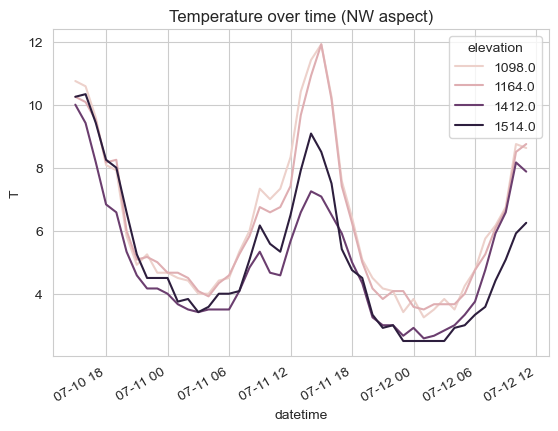

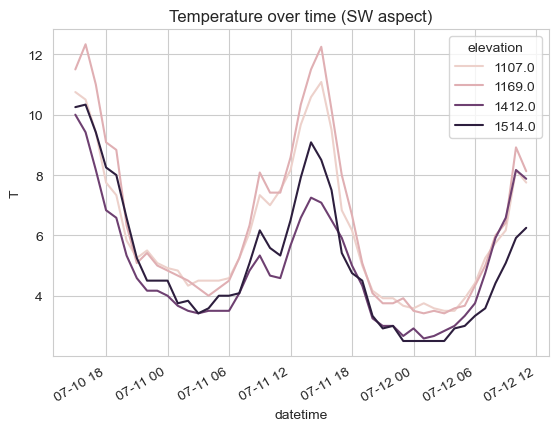

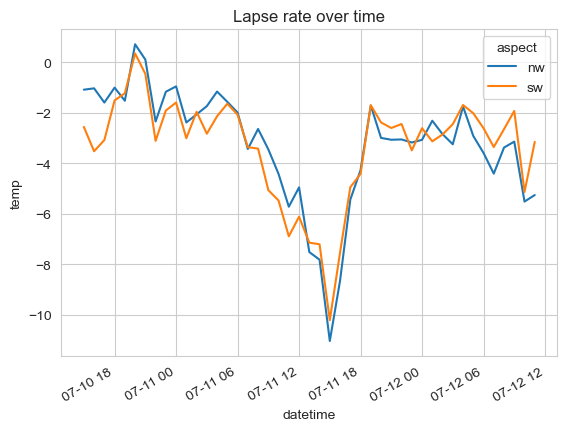

In [ ]:
# calculate lapse rate over time

# resample to 1h
nw_lapse = nw_aspect.groupby('elevation').resample('1H', on='datetime').mean(numeric_only=True)
sw_lapse = sw_aspect.groupby('elevation').resample('1H', on='datetime').mean(numeric_only=True)

fig, ax = plt.subplots(1,1)
sns.lineplot(nw_lapse, x='datetime', y='T', hue='elevation', ax=ax)
ax.set_title('Temperature over time (NW aspect)')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,1)
sns.lineplot(sw_lapse, x='datetime', y='T', hue='elevation')
ax.set_title('Temperature over time (SW aspect)')
fig.autofmt_xdate()

# regress over each 1h bin
nw = nw_lapse.groupby('datetime').apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)
sw = sw_lapse.groupby('datetime').apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)
lapse = pd.DataFrame(dict(nw=nw, sw=sw)) * 1000  # convert to degC/km
lapse = lapse.reset_index()
print(lapse)
lapse = pd.melt(lapse, var_name='aspect', value_name='temp', id_vars='datetime')

fig, ax = plt.subplots(1,1)
sns.lineplot(lapse, x='datetime', y='temp', hue='aspect', ax=ax)
ax.set_title('Lapse rate over time')
fig.autofmt_xdate()

                            nw         sw
datetime                                 
2023-07-10 15:00:00  -1.090524  -2.170263
2023-07-10 16:00:00  -1.036671  -3.525161
2023-07-10 17:00:00  -1.598585  -3.082806
2023-07-10 18:00:00  -1.009036  -1.514795
2023-07-10 19:00:00  -1.527017  -1.228762
2023-07-10 20:00:00   0.706467   0.342575
2023-07-10 21:00:00   0.100620  -0.464897
2023-07-10 22:00:00  -2.348985  -3.114957
2023-07-10 23:00:00  -1.173429  -1.913912
2023-07-11 00:00:00  -0.959434  -1.598314
2023-07-11 01:00:00  -2.387249  -3.010744
2023-07-11 02:00:00  -2.066965  -1.965280
2023-07-11 03:00:00  -1.741012  -2.831141
2023-07-11 04:00:00  -1.163509  -2.141556
2023-07-11 05:00:00  -1.570950  -1.644139
2023-07-11 06:00:00  -1.994688  -2.078732
2023-07-11 07:00:00  -3.434549  -3.362927
2023-07-11 08:00:00  -2.643759  -3.421316
2023-07-11 09:00:00  -3.448721  -5.061760
2023-07-11 10:00:00  -4.424453  -5.476028
2023-07-11 11:00:00  -5.719760  -6.889935
2023-07-11 12:00:00  -4.953771  -6

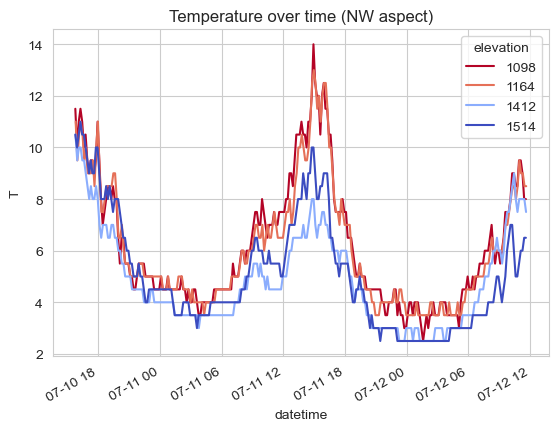

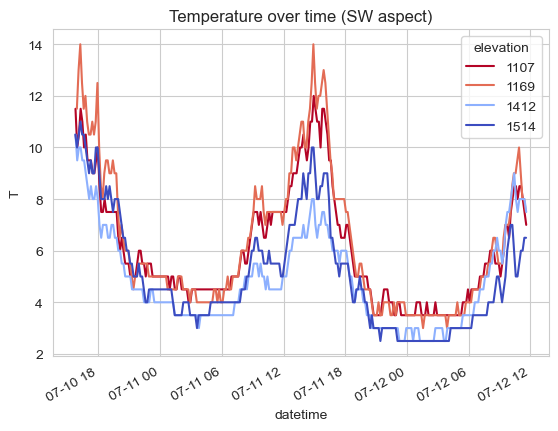

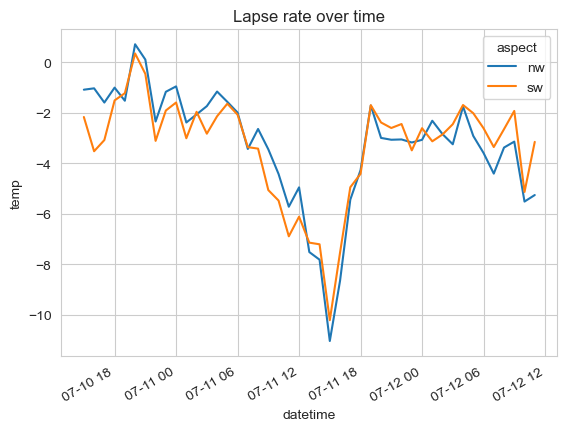

In [ ]:
# lapse rate over time without resampling (all points are used in least-squares minimization)
# Sanity check. Should be close to identical.

fig, ax = plt.subplots(1,1)
sns.lineplot(nw_aspect, x='datetime', y='T', hue='elevation', ax=ax, palette='coolwarm_r')
ax.set_title('Temperature over time (NW aspect)')
fig.autofmt_xdate()

fig, ax = plt.subplots(1,1)
sns.lineplot(sw_aspect, x='datetime', y='T', hue='elevation', palette='coolwarm_r')
ax.set_title('Temperature over time (SW aspect)')
fig.autofmt_xdate()

# lapse over time
nw = nw_aspect.groupby(nw_aspect.datetime.dt.floor('1H')).apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)
sw = sw_aspect.groupby(sw_aspect.datetime.dt.floor('1H')).apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)
lapse = pd.DataFrame(dict(nw=nw, sw=sw))
lapse = lapse * 1000  # convert to degC/km
print(lapse)
lapse = lapse.reset_index()
lapse = pd.melt(lapse, var_name='aspect', value_name='temp', id_vars='datetime')

fig, ax = plt.subplots(1,1)
sns.lineplot(lapse, x='datetime', y='temp', hue='aspect', ax=ax)
ax.set_title('Lapse rate over time')
fig.autofmt_xdate()

## Night-time lapse rate

              datetime        sw        nw
0  2023-07-10 22:00:00 -3.114957 -2.348985
1  2023-07-10 23:00:00 -1.913912 -1.173429
2  2023-07-11 00:00:00 -1.598314 -0.959434
3  2023-07-11 01:00:00 -3.010744 -2.387249
4  2023-07-11 02:00:00 -1.965280 -2.066965
5  2023-07-11 03:00:00 -2.831141 -1.741012
6  2023-07-11 04:00:00 -2.141556 -1.163509
7  2023-07-11 05:00:00 -1.644139 -1.570950
8  2023-07-11 22:00:00 -2.447915 -3.058286
9  2023-07-11 23:00:00 -3.489684 -3.178747
10 2023-07-12 00:00:00 -2.613475 -3.073875
11 2023-07-12 01:00:00 -3.131957 -2.318515
12 2023-07-12 02:00:00 -2.860705 -2.848543
13 2023-07-12 03:00:00 -2.455676 -3.249606
14 2023-07-12 04:00:00 -1.696246 -1.753767
15 2023-07-12 05:00:00 -2.021082 -2.920110

 SW Aspect: LinregressResult(slope=-2.4335489302196356, intercept=6.909622050417303, rvalue=-0.5423719304369612, pvalue=3.6680289670487485e-06, stderr=0.4787380172320165, intercept_stderr=0.6277654764366157)

 NW Aspect: LinregressResult(slope=-2.23831140947587, inter

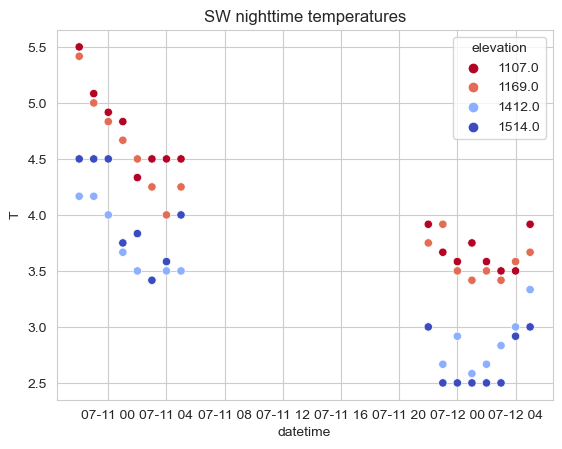

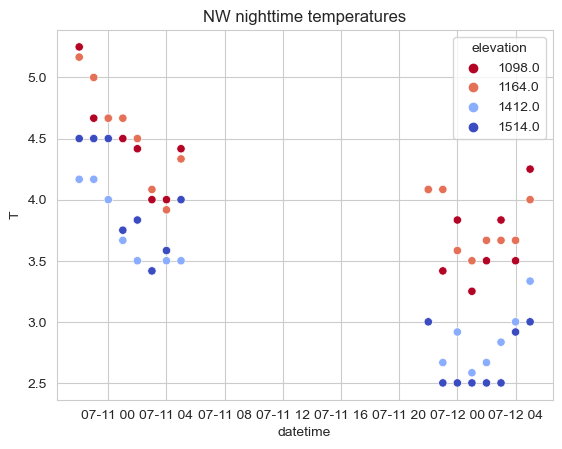

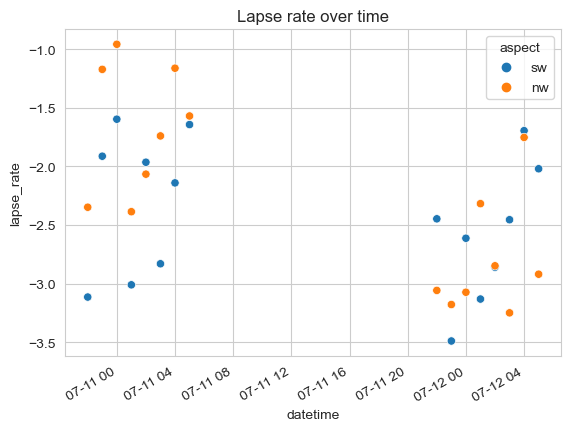

In [ ]:
# times after 2200 and before 0500
nw = nw_aspect.loc[((nw_aspect.datetime.dt.hour >= 22) | (nw_aspect.datetime.dt.hour <= 5))]
sw = sw_aspect[((sw_aspect.datetime.dt.hour >= 22) | (sw_aspect.datetime.dt.hour <= 5))]

sw = sw.groupby('elevation').resample('1H', on='datetime').mean(numeric_only=True).dropna(how='any', subset='T')
nw = nw.groupby('elevation').resample('1H', on='datetime').mean(numeric_only=True).dropna(how='any', subset='T')

fig, ax = plt.subplots(1,1)
sns.scatterplot(sw, x='datetime', y='T', palette='coolwarm_r', hue='elevation')
ax.set_title('SW nighttime temperatures')

fig, ax = plt.subplots(1,1)
sns.scatterplot(nw, x='datetime', y='T', palette='coolwarm_r', hue='elevation')
ax.set_title('NW nighttime temperatures')

# calculate lapse rate
sw_lapse = sw.groupby('datetime').apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)
nw_lapse = nw.groupby('datetime').apply(lambda x: sci.stats.linregress(x['elevation'], x['T']).slope)

lapse = pd.DataFrame(dict(sw=sw_lapse, nw=nw_lapse)) * 1000  # convert to degC/km
lapse = lapse.reset_index()
print(lapse)
lapse = pd.melt(lapse, var_name='aspect', value_name='lapse_rate', id_vars='datetime')  # convert to tidy data

fig, ax = plt.subplots(1,1)
sns.scatterplot(lapse, x='datetime', y='lapse_rate', hue='aspect', ax=ax)
ax.set_title('Lapse rate over time')
fig.autofmt_xdate()

# calculate overall nighttime lapse rate

print("\n SW Aspect:", sci.stats.linregress(sw['elevation']/1000, sw['T']))
print("\n NW Aspect:", sci.stats.linregress(nw['elevation']/1000, nw['T']))